In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
from mlxtend.frequent_patterns import apriori,association_rules
from collections import Counter
from IPython.display import Image
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv('Groceries_dataset-2.csv')
df.head()
df.info()
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())
df.drop_duplicates(inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
       Member_number
count   38765.000000
mean     3003.641868
std      1153.611031
min      1000.000000
25%      2002.000000
50%      3005.000000
75%      4007.000000
max      5000.000000
Member_number      0
Date               0
itemDescription    0
dtype: int64
759


In [3]:
print("="*70)
print("🔍 DATA QUALITY ASSESSMENT")
print("="*70)

# Missing values
print("\n1. Missing Values:")
null_counts = df.isnull().sum()
print(null_counts)
if null_counts.sum() == 0:
    print("No missing values!")
else:
    print(f"Total missing: {null_counts.sum()}")

# Duplicates
print("\n2. Duplicates:")
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count:,}")

if dup_count > 0:
    print(f"🧹 Removing {dup_count:,} duplicates...")
    df.drop_duplicates(inplace=True)
    print("Duplicates removed!")

print(f"Clean dataset: {df.shape}")

🔍 DATA QUALITY ASSESSMENT

1. Missing Values:
Member_number      0
Date               0
itemDescription    0
dtype: int64
No missing values!

2. Duplicates:
Duplicate rows: 0
Clean dataset: (38006, 3)


In [4]:
# Convert dates and extract features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['MonthName'] = df['Date'].dt.month_name()
df['DayOfWeek'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour

print("Date conversion complete!")
print("New columns: Year, Month, MonthName, DayOfWeek, Hour")
display(df.head())

Date conversion complete!
New columns: Year, Month, MonthName, DayOfWeek, Hour


,Member_number,Date,itemDescription,Year,Month,MonthName,DayOfWeek,Hour
0,1808,2015-07-21,tropical fruit,2015,7,July,Tuesday,0
1,2552,2015-01-05,whole milk,2015,1,January,Monday,0
2,2300,2015-09-19,pip fruit,2015,9,September,Saturday,0
3,1187,2015-12-12,other vegetables,2015,12,December,Saturday,0
4,3037,2015-02-01,whole milk,2015,2,February,Sunday,0


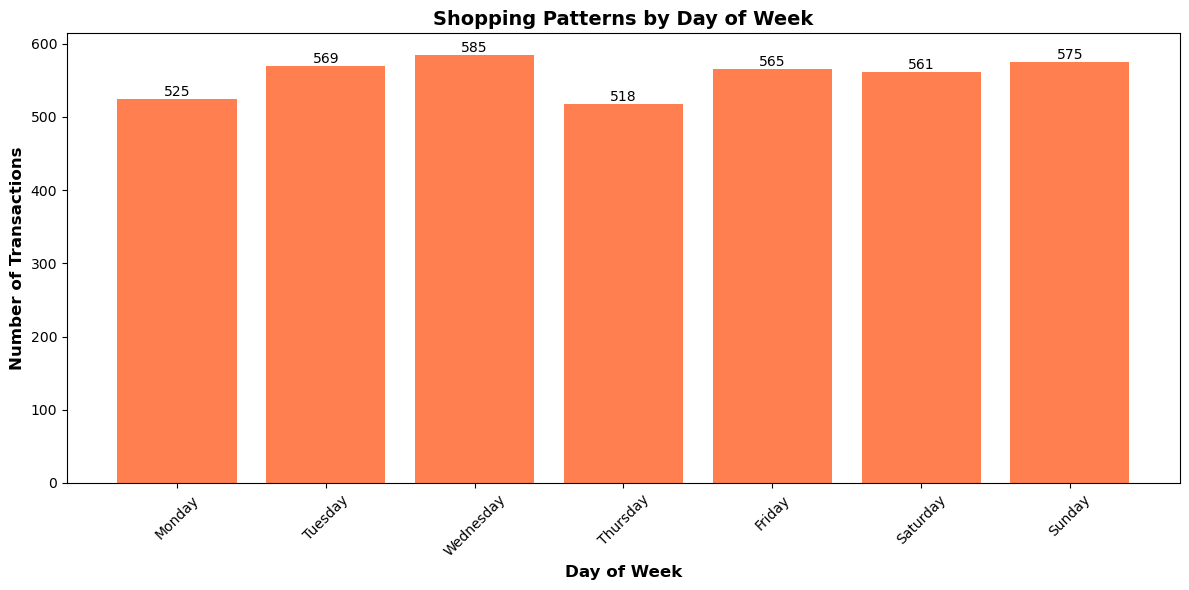

In [5]:
# Analyze purchasing patterns over time
# Shopping patterns by day of week
plt.figure(figsize=(12, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df.groupby('Member_number')['DayOfWeek'].first().value_counts()
day_counts = day_counts.reindex(day_order, fill_value=0)

bars = plt.bar(range(len(day_counts)), day_counts.values, color='coral')
plt.xticks(range(len(day_counts)), day_counts.index, rotation=45)
plt.xlabel('Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Number of Transactions', fontsize=12, fontweight='bold')
plt.title('Shopping Patterns by Day of Week', fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
#creating a basket matrix
basket = (df.groupby(['Member_number', 'itemDescription'])['Date']
          .count().unstack().reset_index().fillna(0).set_index('Member_number'))
basket.head()
#converting the basket matrix to a binary matrix
basket_sets = basket.applymap(lambda x: 1 if x > 0 else 0)


In [7]:
basket_sets.head()

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Support - Support is a relative frequency of an item wthin a dataset.It basically expresses how popular the item is as represented by its proportion to the total items sold.

In [8]:
# creating a frequent itemsets in relation to support, to see the most popular items
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True).sort_values('support', ascending=False)
frequent_itemsets.head(20)

,support,itemsets
36,0.458184,(whole milk)
24,0.376603,(other vegetables)
28,0.349666,(rolls/buns)
32,0.313494,(soda)
37,0.282966,(yogurt)
33,0.233710,(tropical fruit)
29,0.230631,(root vegetables)
4,0.213699,(bottled water)
30,0.206003,(sausage)
57,0.191380,"(whole milk, other vegetables)"


In [9]:
# Creation of the whole milk data frame
whole_milk_df = basket_sets.loc[basket_sets['whole milk'] == 1]
whole_milk_df


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Member_number,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [10]:
frequent_itemsets_whole_milk = apriori(whole_milk_df,min_support=0.15, use_colnames=True).sort_values('support', ascending =False)
frequent_itemsets_whole_milk.head(20)

,support,itemsets
17,1.000000,(whole milk)
28,0.417693,"(whole milk, other vegetables)"
7,0.417693,(other vegetables)
32,0.389698,"(whole milk, rolls/buns)"
10,0.389698,(rolls/buns)
36,0.329787,"(soda, whole milk)"
14,0.329787,(soda)
39,0.328667,"(yogurt, whole milk)"
18,0.328667,(yogurt)
15,0.254199,(tropical fruit)


Based on the frequency of the itemsets in relation to support, whole milk was the most popular so I wanna dive deeper into this so
I can recognize which items were purchased together with whole milk via the associated rules process.

In [11]:
rules = association_rules(frequent_itemsets_whole_milk, metric="confidence", min_threshold=0.5)
rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(['lift','support'], ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,(other vegetables),(whole milk),0.417693,1.0,0.417693,1.0,1.0
1,(rolls/buns),(whole milk),0.389698,1.0,0.389698,1.0,1.0
2,(soda),(whole milk),0.329787,1.0,0.329787,1.0,1.0
3,(yogurt),(whole milk),0.328667,1.0,0.328667,1.0,1.0
4,(tropical fruit),(whole milk),0.254199,1.0,0.254199,1.0,1.0
5,(root vegetables),(whole milk),0.246920,1.0,0.246920,1.0,1.0
6,(bottled water),(whole milk),0.245241,1.0,0.245241,1.0,1.0
7,(sausage),(whole milk),0.233483,1.0,0.233483,1.0,1.0
8,(citrus fruit),(whole milk),0.201568,1.0,0.201568,1.0,1.0
9,(shopping bags),(whole milk),0.199328,1.0,0.199328,1.0,1.0


Taking a stepback away from just analyzing the transactions around whole milk, I will now be looking into what top product pairs are bought together, below. 

In [12]:
# top pairs based on the frequent_itemsets sorted by the support parameter
top_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x:len(x)==2)].sort_values('support',ascending=False)
top_pairs.head(20)

,support,itemsets
57,0.191380,"(whole milk, other vegetables)"
65,0.178553,"(whole milk, rolls/buns)"
75,0.151103,"(soda, whole milk)"
80,0.150590,"(yogurt, whole milk)"
51,0.146742,"(other vegetables, rolls/buns)"
55,0.124166,"(soda, other vegetables)"
58,0.120318,"(yogurt, other vegetables)"
63,0.119805,"(soda, rolls/buns)"
77,0.116470,"(whole milk, tropical fruit)"
68,0.113135,"(whole milk, root vegetables)"


In [13]:
# for better visualization of the top pairs variable sorted by support, BELOW is the bar chart 
top_pairs['itemsets'] = top_pairs['itemsets'].apply(lambda x : ','.join(list(x)))
pairs = top_pairs['itemsets'].head(10)
support_values = top_pairs['support']*100
support_values = support_values.head(10)

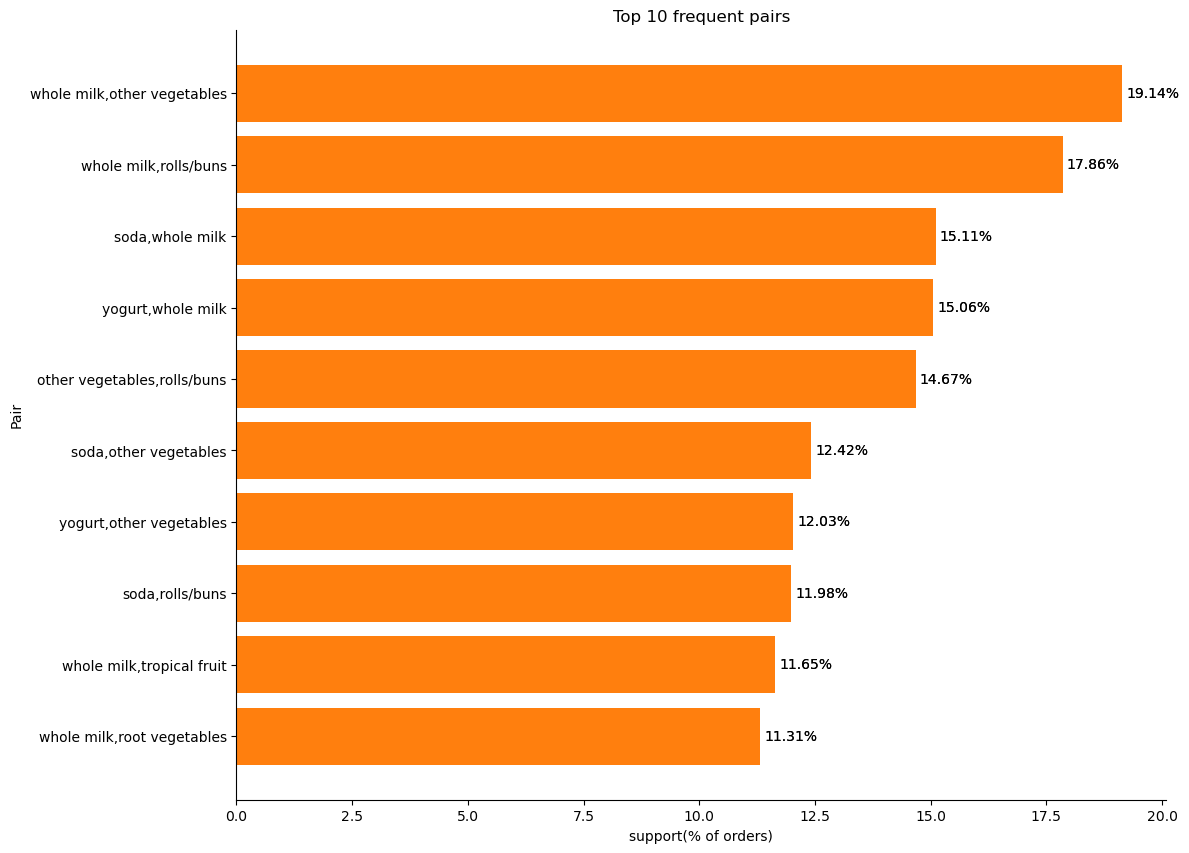

In [14]:
plt.figure(figsize=(12,10))
bars = plt.barh(pairs, support_values)
plt.bar_label(bars, fmt='%.2f%%', padding=3)
bars = plt.barh(pairs, support_values)
plt.bar_label(bars, fmt='%.2f%%', padding=3)
plt.xlabel('support(% of orders)')
plt.ylabel('Pair')
plt.title('Top 10 frequent pairs')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

In [15]:
top_triples = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x : len(x)==3)]
top_triples

,support,itemsets
81,0.082093,"(other vegetables, whole milk, rolls/buns)"
82,0.071832,"(yogurt, whole milk, other vegetables)"


In [16]:
top_triples['itemsets'] = top_triples['itemsets'].apply(lambda x : ','.join(list(x)))
triples = top_triples['itemsets']
triples_support_values = top_triples['support']*100

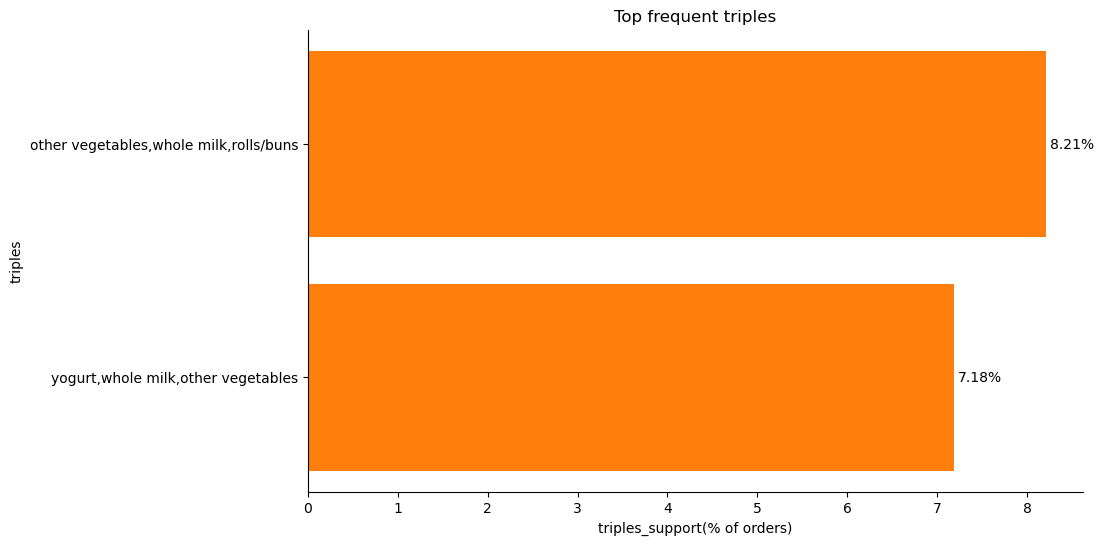

In [17]:
plt.figure(figsize=(10,6))
bars = plt.barh(triples, triples_support_values)
bars = plt.barh(triples, triples_support_values)
plt.bar_label(bars, fmt='%.2f%%', padding=3)
plt.xlabel('triples_support(% of orders)')
plt.ylabel('triples')
plt.title('Top frequent triples')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

CREATING A FUNCTION THAT GIVES BACK EVERY PRODUCT BASED ON THE PARAMETER (PRODUCT; whole milk, eggs, etc) PLACED INSIDE.

In [18]:
# In other words, it returns the items which are likely to be bought by user because he bought the item passed into function

def frequently_bought_together(item, min_sup=0.15):
    """
    Find items frequently bought together with a specific item.
    
    Parameters:
    -----------
    item : str
        Product name to analyze
    min_sup : float
        Minimum support threshold (default: 0.15)
        
    Returns:
    --------
    DataFrame with association rules sorted by lift and support
    """
    if item not in basket_sets.columns:
        print(f"'{item}' not found in products!")
        return pd.DataFrame()
    
    item_df = basket_sets.loc[basket_sets[item] == 1]
    
    if len(item_df) == 0:
        print(f" No transactions found with '{item}'")
        return pd.DataFrame()
    
    print(f"\n🔍 Analyzing '{item}'...")
    print(f"   Found in {len(item_df):,} transactions ({len(item_df)/len(basket_sets)*100:.2f}%)")
    
    freq_items = apriori(item_df, min_support=min_sup, use_colnames=True)
    
    if len(freq_items) == 0:
        print(f" No frequent itemsets found")
        return pd.DataFrame()
    
    rules = association_rules(freq_items, metric="lift", min_threshold=1)
    # ✅ Actually save the sorted result
    rules = rules.sort_values(['lift', 'support'], ascending=False).reset_index(drop=True)
    
    print(f"   ✅ Found {len(rules)} rules")
    
    return rules

In [19]:
frequently_bought_together('whole milk')


🔍 Analyzing 'whole milk'...
   Found in 1,786 transactions (45.82%)
   ✅ Found 60 rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(yogurt),(other vegetables),0.328667,0.417693,0.156775,0.477002,1.141991,1.0,0.019493,1.113401,0.185208,0.265907,0.101851,0.426168
1,"(yogurt, whole milk)",(other vegetables),0.328667,0.417693,0.156775,0.477002,1.141991,1.0,0.019493,1.113401,0.185208,0.265907,0.101851,0.426168
2,(yogurt),"(whole milk, other vegetables)",0.328667,0.417693,0.156775,0.477002,1.141991,1.0,0.019493,1.113401,0.185208,0.265907,0.101851,0.426168
3,(other vegetables),(yogurt),0.417693,0.328667,0.156775,0.375335,1.141991,1.0,0.019493,1.074708,0.213523,0.265907,0.069515,0.426168
4,"(whole milk, other vegetables)",(yogurt),0.417693,0.328667,0.156775,0.375335,1.141991,1.0,0.019493,1.074708,0.213523,0.265907,0.069515,0.426168
5,(other vegetables),"(yogurt, whole milk)",0.417693,0.328667,0.156775,0.375335,1.141991,1.0,0.019493,1.074708,0.213523,0.265907,0.069515,0.426168
6,(other vegetables),(rolls/buns),0.417693,0.389698,0.179171,0.428954,1.100736,1.0,0.016397,1.068745,0.157163,0.285205,0.064323,0.444362
7,(rolls/buns),(other vegetables),0.389698,0.417693,0.179171,0.459770,1.100736,1.0,0.016397,1.077887,0.149954,0.285205,0.072259,0.444362
8,"(whole milk, other vegetables)",(rolls/buns),0.417693,0.389698,0.179171,0.428954,1.100736,1.0,0.016397,1.068745,0.157163,0.285205,0.064323,0.444362
9,"(whole milk, rolls/buns)",(other vegetables),0.389698,0.417693,0.179171,0.459770,1.100736,1.0,0.016397,1.077887,0.149954,0.285205,0.072259,0.444362


In [20]:
frequently_bought_together('soda')


🔍 Analyzing 'soda'...
   Found in 1,222 transactions (31.35%)
   ✅ Found 68 rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(yogurt),(whole milk),0.310966,0.481997,0.173486,0.557895,1.157466,1.0,0.023602,1.171674,0.197441,0.280053,0.146520,0.458913
1,"(yogurt, soda)",(whole milk),0.310966,0.481997,0.173486,0.557895,1.157466,1.0,0.023602,1.171674,0.197441,0.280053,0.146520,0.458913
2,(yogurt),"(soda, whole milk)",0.310966,0.481997,0.173486,0.557895,1.157466,1.0,0.023602,1.171674,0.197441,0.280053,0.146520,0.458913
3,(whole milk),(yogurt),0.481997,0.310966,0.173486,0.359932,1.157466,1.0,0.023602,1.076502,0.262631,0.280053,0.071065,0.458913
4,"(soda, whole milk)",(yogurt),0.481997,0.310966,0.173486,0.359932,1.157466,1.0,0.023602,1.076502,0.262631,0.280053,0.071065,0.458913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,(newspapers),(soda),0.158756,1.000000,0.158756,1.000000,1.000000,1.0,0.000000,inf,0.000000,0.158756,0.000000,0.579378
64,(soda),(whipped/sour cream),1.000000,0.154664,0.154664,0.154664,1.000000,1.0,0.000000,1.000000,0.000000,0.154664,0.000000,0.577332
65,(whipped/sour cream),(soda),0.154664,1.000000,0.154664,1.000000,1.000000,1.0,0.000000,inf,0.000000,0.154664,0.000000,0.577332
66,(soda),(brown bread),1.000000,0.150573,0.150573,0.150573,1.000000,1.0,0.000000,1.000000,0.000000,0.150573,0.000000,0.575286


In [21]:
# validation approach
member_id = 1000
member_items = df[df['Member_number']==member_id]['itemDescription'].unique()

print(f"Member {member_id} purchased {len(member_items)} items:")
print(member_items)

# Check if they bought whole milk
if 'whole milk' in member_items:
    print("Member bought whole milk")
    
    # Get recommendations
    recommendations = frequently_bought_together('whole milk')
    
    if len(recommendations) > 0:
        top_recommendations = recommendations['consequents'].unique()[:5]
        print(f"\nTop 5 recommendations: {top_recommendations}")
        
        # Check which they actually bought
        for rec in top_recommendations:
            rec_items = list(rec)
            bought = [item for item in rec_items if item in member_items]
            if bought:
                print(f"Also bought: {bought}")
            else:
                print(f"Didn't buy: {rec_items}")

Member 1000 purchased 11 items:
['soda' 'canned beer' 'sausage' 'whole milk' 'pickled vegetables'
 'misc. beverages' 'semi-finished bread' 'hygiene articles' 'yogurt'
 'pastry' 'salty snack']
Member bought whole milk

🔍 Analyzing 'whole milk'...
   Found in 1,786 transactions (45.82%)
   ✅ Found 60 rules

Top 5 recommendations: [frozenset({'other vegetables'})
 frozenset({'whole milk', 'other vegetables'}) frozenset({'yogurt'})
 frozenset({'yogurt', 'whole milk'}) frozenset({'rolls/buns'})]
Didn't buy: ['other vegetables']
Also bought: ['whole milk']
Also bought: ['yogurt']
Also bought: ['yogurt', 'whole milk']
Didn't buy: ['rolls/buns']


In [22]:
# Now I will be looking into the association rules of the frequent itemsets.
tot_rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
tot_rules[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']].sort_values(['lift','support'], ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
89,(yogurt),"(whole milk, other vegetables)",0.282966,0.191380,0.071832,0.253853,1.326434
88,"(whole milk, other vegetables)",(yogurt),0.191380,0.282966,0.071832,0.375335,1.326434
90,(whole milk),"(yogurt, other vegetables)",0.458184,0.120318,0.071832,0.156775,1.303003
87,"(yogurt, other vegetables)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003
77,(sausage),(yogurt),0.206003,0.282966,0.075423,0.366127,1.293892
76,(yogurt),(sausage),0.282966,0.206003,0.075423,0.266546,1.293892
91,(other vegetables),"(yogurt, whole milk)",0.376603,0.150590,0.071832,0.190736,1.266589
86,"(yogurt, whole milk)",(other vegetables),0.150590,0.376603,0.071832,0.477002,1.266589
54,"(whole milk, other vegetables)",(rolls/buns),0.191380,0.349666,0.082093,0.428954,1.226753
59,(rolls/buns),"(whole milk, other vegetables)",0.349666,0.191380,0.082093,0.234776,1.226753


In [23]:
# Add after generating association rules
print("FILTERING FOR ACTIONABLE RULES")

actionable = tot_rules[
    (tot_rules['confidence'] > 0.3) &  # 30%+ confidence
    (tot_rules['lift'] > 1.5) &        # Strong association
    (tot_rules['support'] > 0.05)      # Appears in 5%+ transactions
]

print(f"Found {len(actionable)} highly actionable rules")
print("Criteria: Confidence > 20%, Lift > 1.2")

if len(actionable) > 0:
    print("\nTop 10 Actionable Rules:")
    for idx, row in actionable.head(10).iterrows():
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))
        print(f"\n{idx+1}. {ant} → {cons}")
        print(f"   Confidence: {row['confidence']:.1%}")
        print(f"   Lift: {row['lift']:.2f}")
        print(f"   Support: {row['support']:.1%}")

FILTERING FOR ACTIONABLE RULES
Found 0 highly actionable rules
Criteria: Confidence > 20%, Lift > 1.2


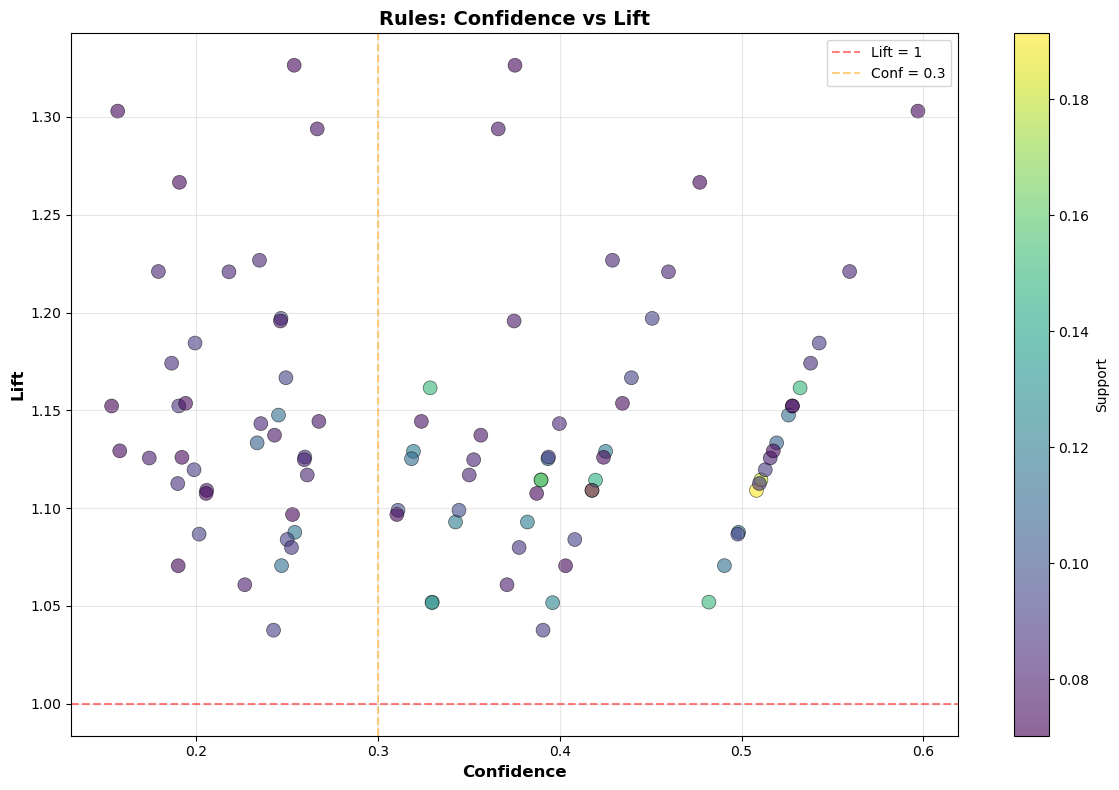

In [24]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tot_rules['confidence'], tot_rules['lift'],
                     c=tot_rules['support'], cmap='viridis',
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Support')
plt.xlabel('Confidence', fontsize=12, fontweight='bold')
plt.ylabel('Lift', fontsize=12, fontweight='bold')
plt.title('Rules: Confidence vs Lift', fontsize=14, fontweight='bold')

plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Lift = 1')
plt.axvline(x=0.3, color='orange', linestyle='--', alpha=0.5, label='Conf = 0.3')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

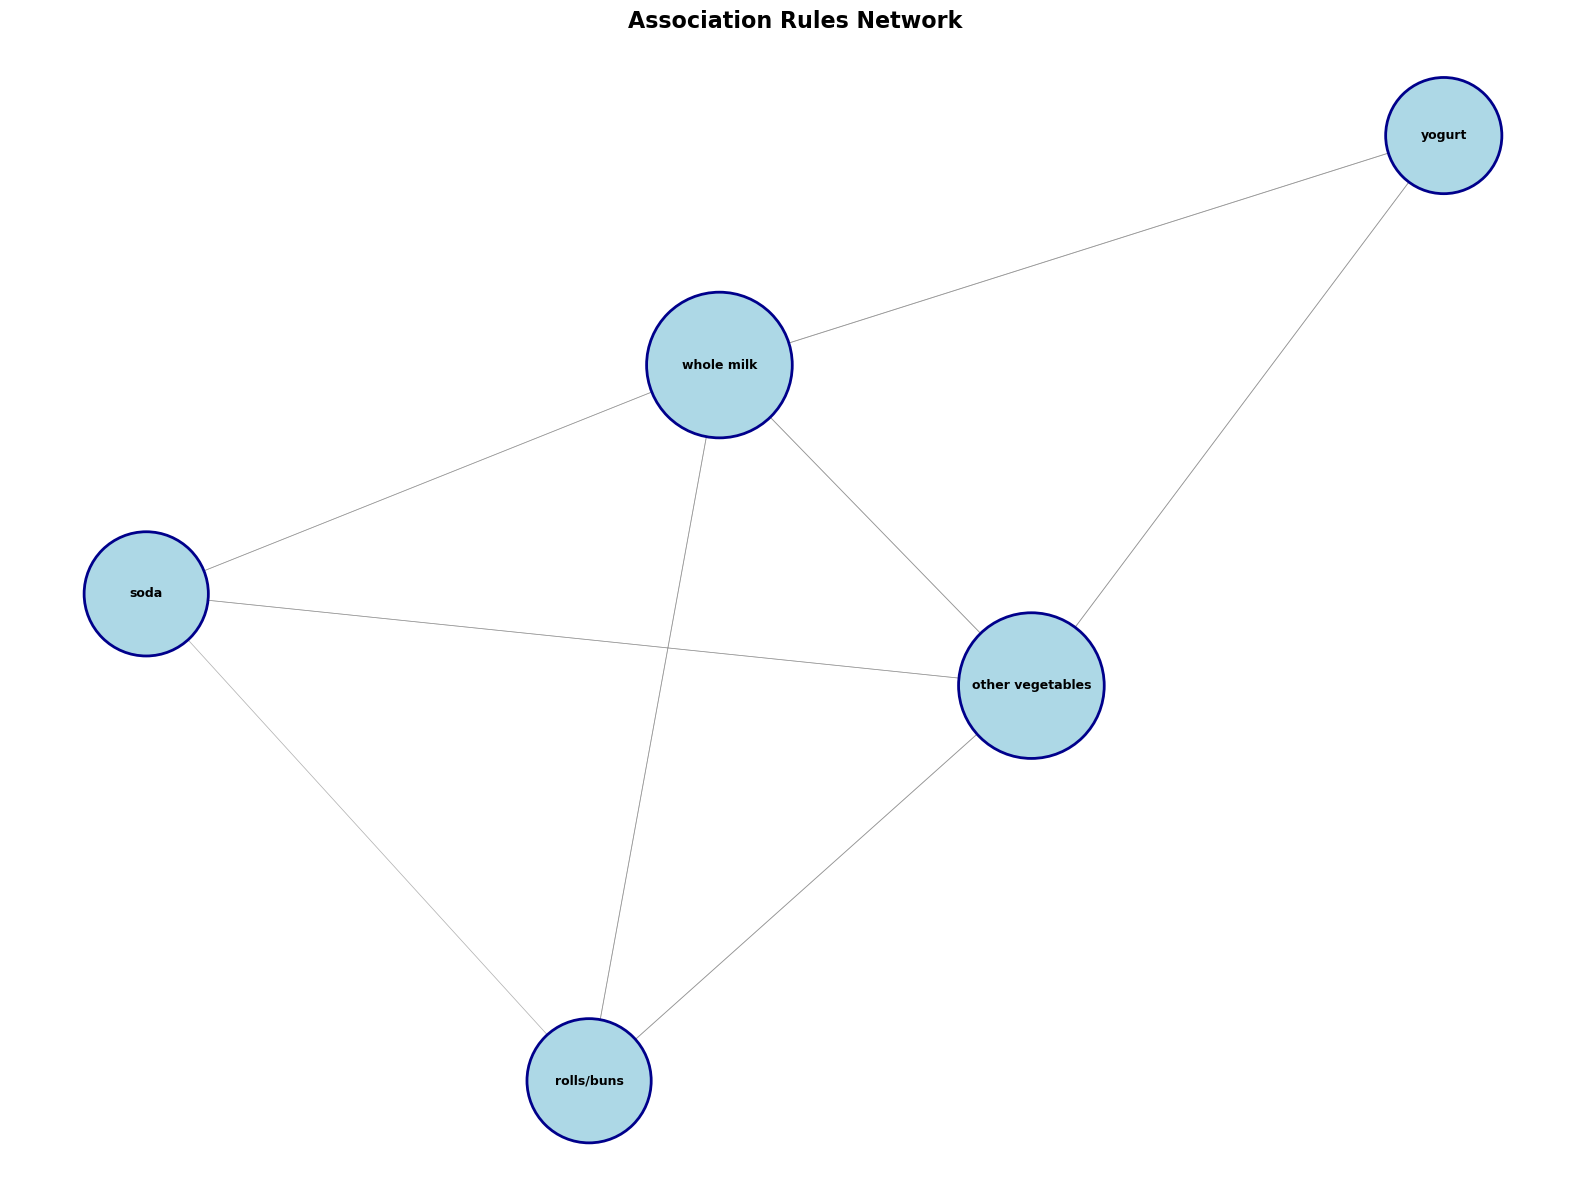

In [25]:
import networkx as nx

plt.figure(figsize=(16, 12))
G = nx.DiGraph()

# Add top 15 rules
for idx, row in tot_rules.head(15).iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    G.add_edge(ant, cons, weight=row['lift'])

# Layout
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

# Draw nodes (size based on degree)
node_sizes = [3000 + G.degree(node) * 1000 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, 
                       node_color='lightblue', 
                       edgecolors='darkblue', linewidths=2)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

# Draw edges (width based on lift)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(G, pos, width=[w*0.5 for w in weights],
                       alpha=0.6, edge_color='gray',
                       arrows=True, arrowsize=20)

plt.title('Association Rules Network', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# creating a rule column that shows the antecedents and consequents
tot_rules['rule'] = tot_rules['antecedents'].apply(lambda x: ','.join(list(x))) + ' -> ' + tot_rules['consequents'].apply(lambda x: ','.join(list(x)))
tot_rules[['rule', 'support', 'confidence', 'lift']].sort_values(['lift','support'], ascending=False)

,rule,support,confidence,lift
89,"yogurt -> whole milk,other vegetables",0.071832,0.253853,1.326434
88,"whole milk,other vegetables -> yogurt",0.071832,0.375335,1.326434
90,"whole milk -> yogurt,other vegetables",0.071832,0.156775,1.303003
87,"yogurt,other vegetables -> whole milk",0.071832,0.597015,1.303003
77,sausage -> yogurt,0.075423,0.366127,1.293892
...,...,...,...,...
5,whole milk -> soda,0.151103,0.329787,1.051973
10,soda -> other vegetables,0.124166,0.396072,1.051695
11,other vegetables -> soda,0.124166,0.329700,1.051695
38,other vegetables -> tropical fruit,0.091329,0.242507,1.037642


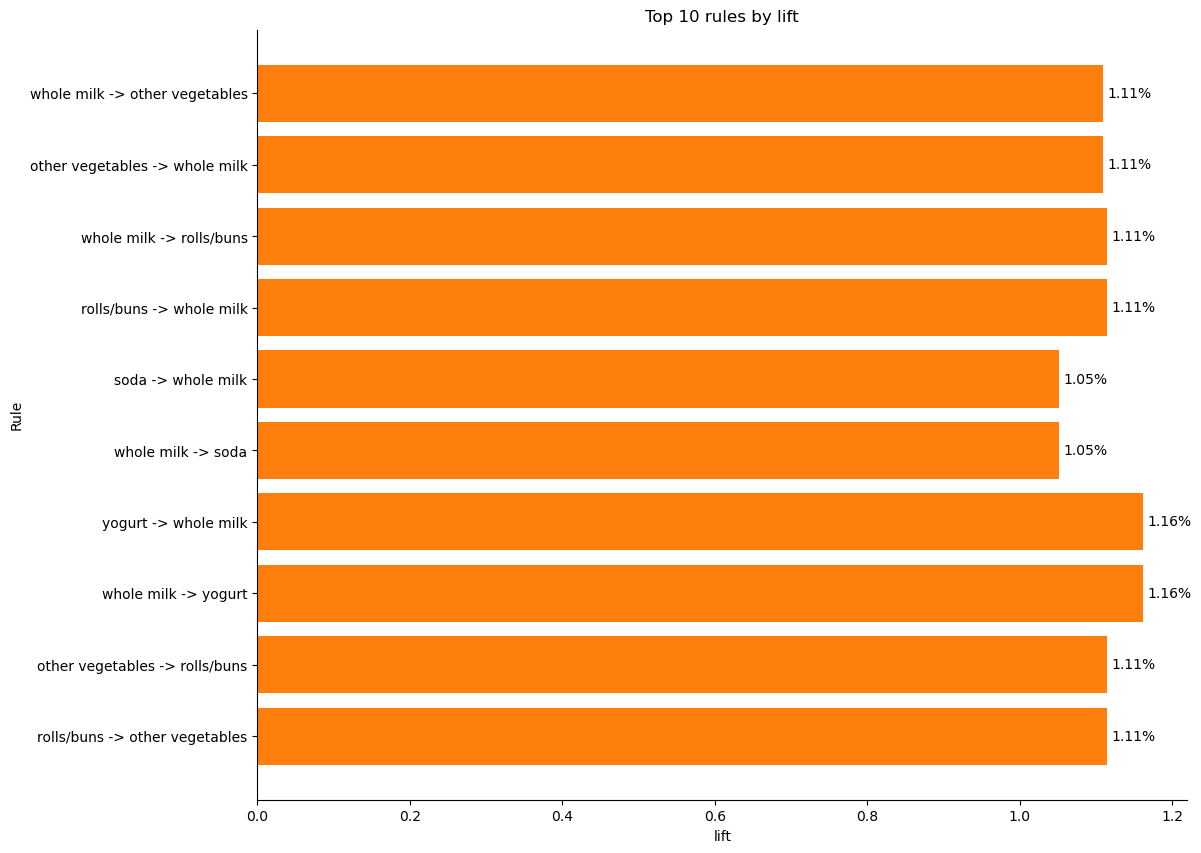

In [27]:
plt.figure(figsize=(12,10))
bars = plt.barh(tot_rules['rule'].head(10), tot_rules['lift'].head(10))
bars = plt.barh(tot_rules['rule'].head(10), tot_rules['lift'].head(10))
plt.bar_label(bars, fmt='%.2f%%', padding=3)
plt.xlabel('lift')
plt.ylabel('Rule')
plt.title('Top 10 rules by lift')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

CONFIDENCE AND LIFT ARE ABSOLUTELY CRUCIAL IN ANY MARKET BASKET ANALYSIS DETERMINATION BECAUSE IT HELPS US DEERMINE HOW OFTEN PRODUCTS GO TOGETHER WHEN SHOPPING; CONFIDENCE & IF THIS IS BY RANDOM CHANCE; LIFT.

LIFT BY FAR IS THE PLAYS THE ULTIMATE ROLE WHEN TRYING TO DELIVER RECOMMENDATION TO STAKEHOLDERS BECAUSE IT HELPS CORRECT THE INITIAL POPULARITY METRIC DEDUCED FROM THE SUPPORT TERMINOLOGY.

LIFT > 1 = +VE ASSOCIATION
LIFT < 1 = -VE ASSSOCIATION
LIFT = 1 = NO ASSOCIATION AT ALL

IT IS ALSO IMPORTANT TO NOTE THAT WE NEED OUR CONFIDENCE LEVELS TO BE > 0.2 (20%)

In [28]:
# Use & instead of 'and', and wrap each condition in parentheses
tot_rules[(tot_rules['confidence'] > 0.2) & (tot_rules['lift'] > 1)][['rule', 'support', 'confidence', 'lift']].sort_values(['lift','support'], ascending=False).head(10)

,rule,support,confidence,lift
89,"yogurt -> whole milk,other vegetables",0.071832,0.253853,1.326434
88,"whole milk,other vegetables -> yogurt",0.071832,0.375335,1.326434
87,"yogurt,other vegetables -> whole milk",0.071832,0.597015,1.303003
77,sausage -> yogurt,0.075423,0.366127,1.293892
76,yogurt -> sausage,0.075423,0.266546,1.293892
86,"yogurt,whole milk -> other vegetables",0.071832,0.477002,1.266589
54,"whole milk,other vegetables -> rolls/buns",0.082093,0.428954,1.226753
59,"rolls/buns -> whole milk,other vegetables",0.082093,0.234776,1.226753
55,"rolls/buns,other vegetables -> whole milk",0.082093,0.559441,1.220996
56,"whole milk,rolls/buns -> other vegetables",0.082093,0.459770,1.220834


In [29]:
print("BUSINESS RECOMMENDATIONS")
print("="*60)
print("\n1. PRODUCT PLACEMENT:")
for idx, row in top_pairs.head(3).iterrows():
    print(f"   • Place {row['itemsets']} together")

print("\n2. PROMOTIONAL BUNDLES:")
for idx, row in actionable.head(3).iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"   • Bundle: {ant} + {cons} (Lift: {row['lift']:.2f})")

print("\n3. CROSS-SELLING OPPORTUNITIES:")
for idx, row in tot_rules.nlargest(3, 'lift').iterrows():
    ant = ', '.join(list(row['antecedents']))
    cons = ', '.join(list(row['consequents']))
    print(f"   • When customer buys {ant}, suggest {cons}")

BUSINESS RECOMMENDATIONS

1. PRODUCT PLACEMENT:
   • Place whole milk,other vegetables together
   • Place whole milk,rolls/buns together
   • Place soda,whole milk together

2. PROMOTIONAL BUNDLES:

3. CROSS-SELLING OPPORTUNITIES:
   • When customer buys yogurt, suggest whole milk, other vegetables
   • When customer buys whole milk, other vegetables, suggest yogurt
   • When customer buys whole milk, suggest yogurt, other vegetables
